In [5]:
import torch
from torch import Tensor
import numpy as np

import matplotlib.pyplot as plt

$$
(n+1) P_{n+1}(x) = (2n + 1) x P_n (x) - n P_{n-1}(x)
$$

donde
$$
P_0(x) = 1, P_1(x) = x
$$

In [183]:
# genera polinomios de legendre usando recurrencia
def Pl(n, x):
    if n == 0:
        return 0*x + 1 # esto hace que devuelva un tensor
    elif n == 1:
        return x
    else:
        n = n - 1 # ya la formula esta en P(n+1,x)
        p1 = (2*n + 1) * x * Pl(n, x)
        p2 = n * Pl(n-1,x)
        return (p1 - p2 )/(n+1)

In [7]:
# el espacio de grafico
x = torch.Tensor([i for i in range(10)])
x.requires_grad_()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], requires_grad=True)

In [60]:
N = 50
x = torch.linspace(-1,1,N)
x.requires_grad_()

tensor([-1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959, -0.7551, -0.7143,
        -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694, -0.4286, -0.3878,
        -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429, -0.1020, -0.0612,
        -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,  0.2245,  0.2653,
         0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,  0.5510,  0.5918,
         0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,  0.8776,  0.9184,
         0.9592,  1.0000], requires_grad=True)

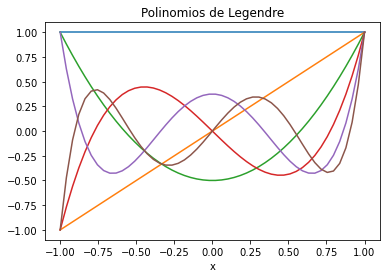

In [23]:
xs = x.detach()
for l in range(0,5+1):
    plt.plot(xs, Pl(l,xs))

plt.title('Polinomios de Legendre')
plt.xlabel('x')
plt.show()

Ahora queremos que se comporte similar a los polinomios de Legendre de otras librerias

In [10]:
from numpy.polynomial.legendre import Legendre

queremos proveer de los metodos:

The Legendre class provides the standard Python numerical methods
'+', '-', '*', '//', '%', 'divmod', '**', and '()' 

In [12]:
coef = Tensor([1,2,3])
coef.requires_grad_()

result = 0
for idx,C in enumerate(coef):
    result += C * Pl(idx, x)

result

tensor([1., 2., 3.], requires_grad=True)

Y la derivada
$$
\frac{d}{dx} P_n(x) = \frac{n}{x^2 - 1} (x P_n - P_{n-1})
$$

In [184]:
# genera derivadas polinomios de legendre usando recurrencia
def dxPl(n, x):
    if n == 0:
        return 0*x + 0
    elif n == 1:
        return 0*x + 1
    else:
        n = n-1 # la regla es para n+1
        return (n+1)* Pl(n,x) + x * dxPl(n,x)


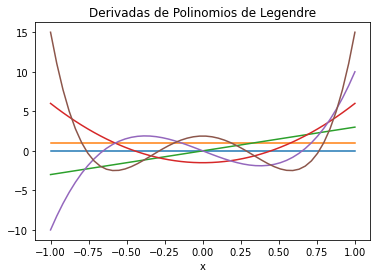

In [22]:
xs = x.detach()
for l in range(0,5+1):
    plt.plot(xs, dxPl(l,xs))
plt.title('Derivadas de Polinomios de Legendre')
plt.xlabel('x')
plt.show()

aqui una implementación para crear el grafo de autoderivación implementando lo que sabemos de los polinomios de legendre

In [214]:
class PLegendre(torch.autograd.Function):
    """A legendre polynomials that work with torch grad"""

    @staticmethod
    def setup_context(ctx, inputs, output):
        n,input = inputs
        ctx.constant = n
        ctx.save_for_backward(input)


    @staticmethod
    def forward(n, input):
        output = Pl(n, input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        n = ctx.constant

        # grad de n, grad * dPl/dx
        return None, grad_output * dxPl(n,input)

# para inicializar los setup_context
# se usa un wrapper      
def torchPl(n, input):
    return PLegendre.apply(n,input)

In [222]:
class PLegendre(torch.autograd.Function):
    """A legendre polynomials that work with torch grad"""

    @staticmethod
    def forward(ctx, n, input):
        ctx.set_materialize_grads(False)
        ctx.save_for_backward(input)
        ctx.n = n

        output = Pl(n, input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        n = ctx.n

        # grad de n, grad * dPl/dx
        return None, grad_output * dxPl(n,input)

# para inicializar los setup_context
# se usa un wrapper      
def torchPl(n, input):
    return PLegendre.apply(n,input)

In [223]:
N = 50
x = torch.linspace(-1,1,N)
x.requires_grad_();

In [224]:
P2 = torchPl

n = 3
P2(n,x)

tensor([-1.0000, -0.7674, -0.5588, -0.3732, -0.2094, -0.0666,  0.0563,  0.1603,
         0.2466,  0.3159,  0.3695,  0.4083,  0.4333,  0.4455,  0.4461,  0.4359,
         0.4160,  0.3875,  0.3513,  0.3085,  0.2600,  0.2070,  0.1504,  0.0913,
         0.0306, -0.0306, -0.0913, -0.1504, -0.2070, -0.2600, -0.3085, -0.3513,
        -0.3875, -0.4160, -0.4359, -0.4461, -0.4455, -0.4333, -0.4083, -0.3695,
        -0.3159, -0.2466, -0.1603, -0.0563,  0.0666,  0.2094,  0.3732,  0.5588,
         0.7674,  1.0000], grad_fn=<PLegendreBackward>)

In [225]:
L2 = ((x - P2(n,x))**2).sum()

In [226]:
L2.backward()

In [233]:
N = 50
x = torch.linspace(-1,1,N, dtype=torch.float64)
x.requires_grad_()

tensor([-1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959, -0.7551, -0.7143,
        -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694, -0.4286, -0.3878,
        -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429, -0.1020, -0.0612,
        -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,  0.2245,  0.2653,
         0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,  0.5510,  0.5918,
         0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,  0.8776,  0.9184,
         0.9592,  1.0000], dtype=torch.float64, requires_grad=True)

In [235]:
torch.autograd.gradcheck(P2, (3,x))

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Tensor'

como se observa, la manera correcta de utilizar es
```python
P2 = PLegendre.apply
P2(n,x)
```

Pues entonces guarda el grafo computacional correcto

In [121]:
import math

dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

In [122]:
# que polinomio de legendre usar
n = 3

learning_rate = 5e-6
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = torchPl

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(n,c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

3
<class 'int'>
3
<class 'int'>


TypeError: can't multiply sequence by non-int of type 'tuple'

In [ ]:
class LegendrePolynomial(torch.autograd.Function):
    """ Generate a sum of legendre polynomials that work with torch grad"""
    def __init__(self, coef, domain=None):
        self.coef = coef
        self.domain = domain

    def __call__(self, x):
        result = 0
        for idx,C in enumerate(self.coef):
            result += C * Pl(idx, x)
        return result

    def forward(ctx, input):
        ctx.save_for_backward(input)
        return self.__call__(input)
    
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output * 
        

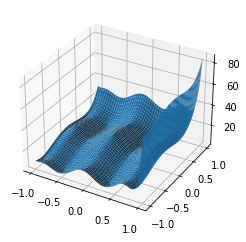

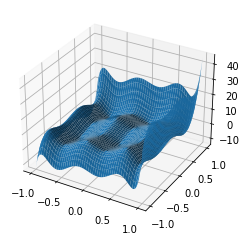

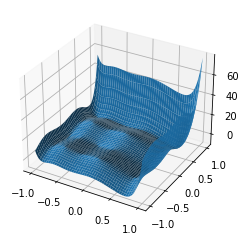

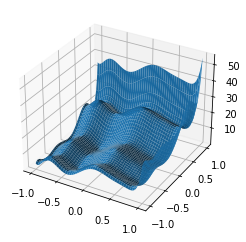

In [ ]:
xL,xR = -1,1
yL, yR = -1,1


import matplotlib.pyplot as plt
xs = torch.linspace(xL, xR, steps=100)
ys = torch.linspace(yL, yR, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')

for i in range(4):
    coefx = Tensor([np.random.randint(10) for i in range(9)])
    coefy = Tensor([np.random.randint(10) for i in range(5+i)])
    fx = PLegendre(coefx, domain=[xL,xR])
    fy = PLegendre(coefy, domain=[yL,yR])
    z = fx(x) + fy(y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x.detach(), y.detach(), z.detach())
    plt.show()